In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
RANDOM_STATE = 42

In [3]:
DATASET_PATH = './datasets/clients.csv'
#DATASET_PATH = "https://raw.githubusercontent.com/evgpat/edu_stepik_from_idea_to_mvp/main/datasets/clients.csv"

In [35]:
# загрузка данных
df = pd.read_csv(DATASET_PATH)

## Описание 

**Целевая переменная**
- `satisfaction`: удовлетворенность клиента полетом, бинарная (*satisfied* или *neutral or dissatisfied*)

**Признаки**
- `Gender` (categorical: _Male_ или _Female_): пол клиента
- `Age` (numeric, int): количество полных лет
- `Customer Type` (categorical: _Loyal Customer_ или _disloyal Customer_): лоялен ли клиент авиакомпании?
- `Type of Travel` (categorical: _Business travel_ или _Personal Travel_): тип поездки
- `Class` (categorical: _Business_ или _Eco_, или _Eco Plus_): класс обслуживания в самолете
- `Flight Distance` (numeric, int): дальность перелета (в милях)
- `Departure Delay in Minutes` (numeric, int): задержка отправления (неотрицательная)
- `Arrival Delay in Minutes` (numeric, int): задержка прибытия (неотрицательная)
- `Inflight wifi service` (categorical, int): оценка клиентом интернета на борту
- `Departure/Arrival time convenient` (categorical, int): оценка клиентом удобство времени прилета и вылета
- `Ease of Online booking` (categorical, int): оценка клиентом удобства онлайн-бронирования
- `Gate location` (categorical, int): оценка клиентом расположения выхода на посадку в аэропорту
- `Food and drink` (categorical, int): оценка клиентом еды и напитков на борту
- `Online boarding` (categorical, int): оценка клиентом выбора места в самолете
- `Seat comfort` (categorical, int): оценка клиентом удобства сиденья
- `Inflight entertainment` (categorical, int): оценка клиентом развлечений на борту
- `On-board service` (categorical, int): оценка клиентом обслуживания на борту
- `Leg room service` (categorical, int): оценка клиентом места в ногах на борту
- `Baggage handling` (categorical, int): оценка клиентом обращения с багажом
- `Checkin service` (categorical, int): оценка клиентом регистрации на рейс
- `Inflight service` (categorical, int): оценка клиентом обслуживания на борту
- `Cleanliness` (categorical, int): оценка клиентом чистоты на борту

## Разведочный анализ

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   Gender                             129549 non-null  object 
 2   Age                                129564 non-null  float64
 3   Customer Type                      129803 non-null  object 
 4   Type of Travel                     129779 non-null  object 
 5   Class                              129764 non-null  object 
 6   Flight Distance                    129786 non-null  float64
 7   Departure Delay in Minutes         129773 non-null  float64
 8   Arrival Delay in Minutes           129371 non-null  float64
 9   Inflight wifi service              129835 non-null  float64
 10  Departure/Arrival time convenient  129831 non-null  float64
 11  Ease of Online booking             1298

In [36]:
# Пропусков меньше 1%, поэтому их можно удалить
df.dropna(inplace=True)

### Распределение оценок удовлетворённости

In [37]:
#df['satisfaction'] = df['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)
TARGET = 'satisfaction'

In [38]:
names = ["Satisfied","Dissatisfied", "No data"]
#names = ["Satisfied","Dissatisfied"]
fig=px.pie(df,values=df[TARGET].value_counts(),
           names=names,title="<b>Satisfied And Dissatisfied Ratio",
           hole=.6,
       color_discrete_sequence=px.colors.qualitative.Pastel,template="plotly")
fig.update_layout(title_font_size=30)
fig.show()

20% No Data это много, но пока не понятно, что с ними делать, поэтому проигнорируем их

In [39]:
df.drop(df[df['satisfaction'] == '-'].index, inplace=True)

### **Таблица корреляции всех числовых признаков**

<AxesSubplot:>

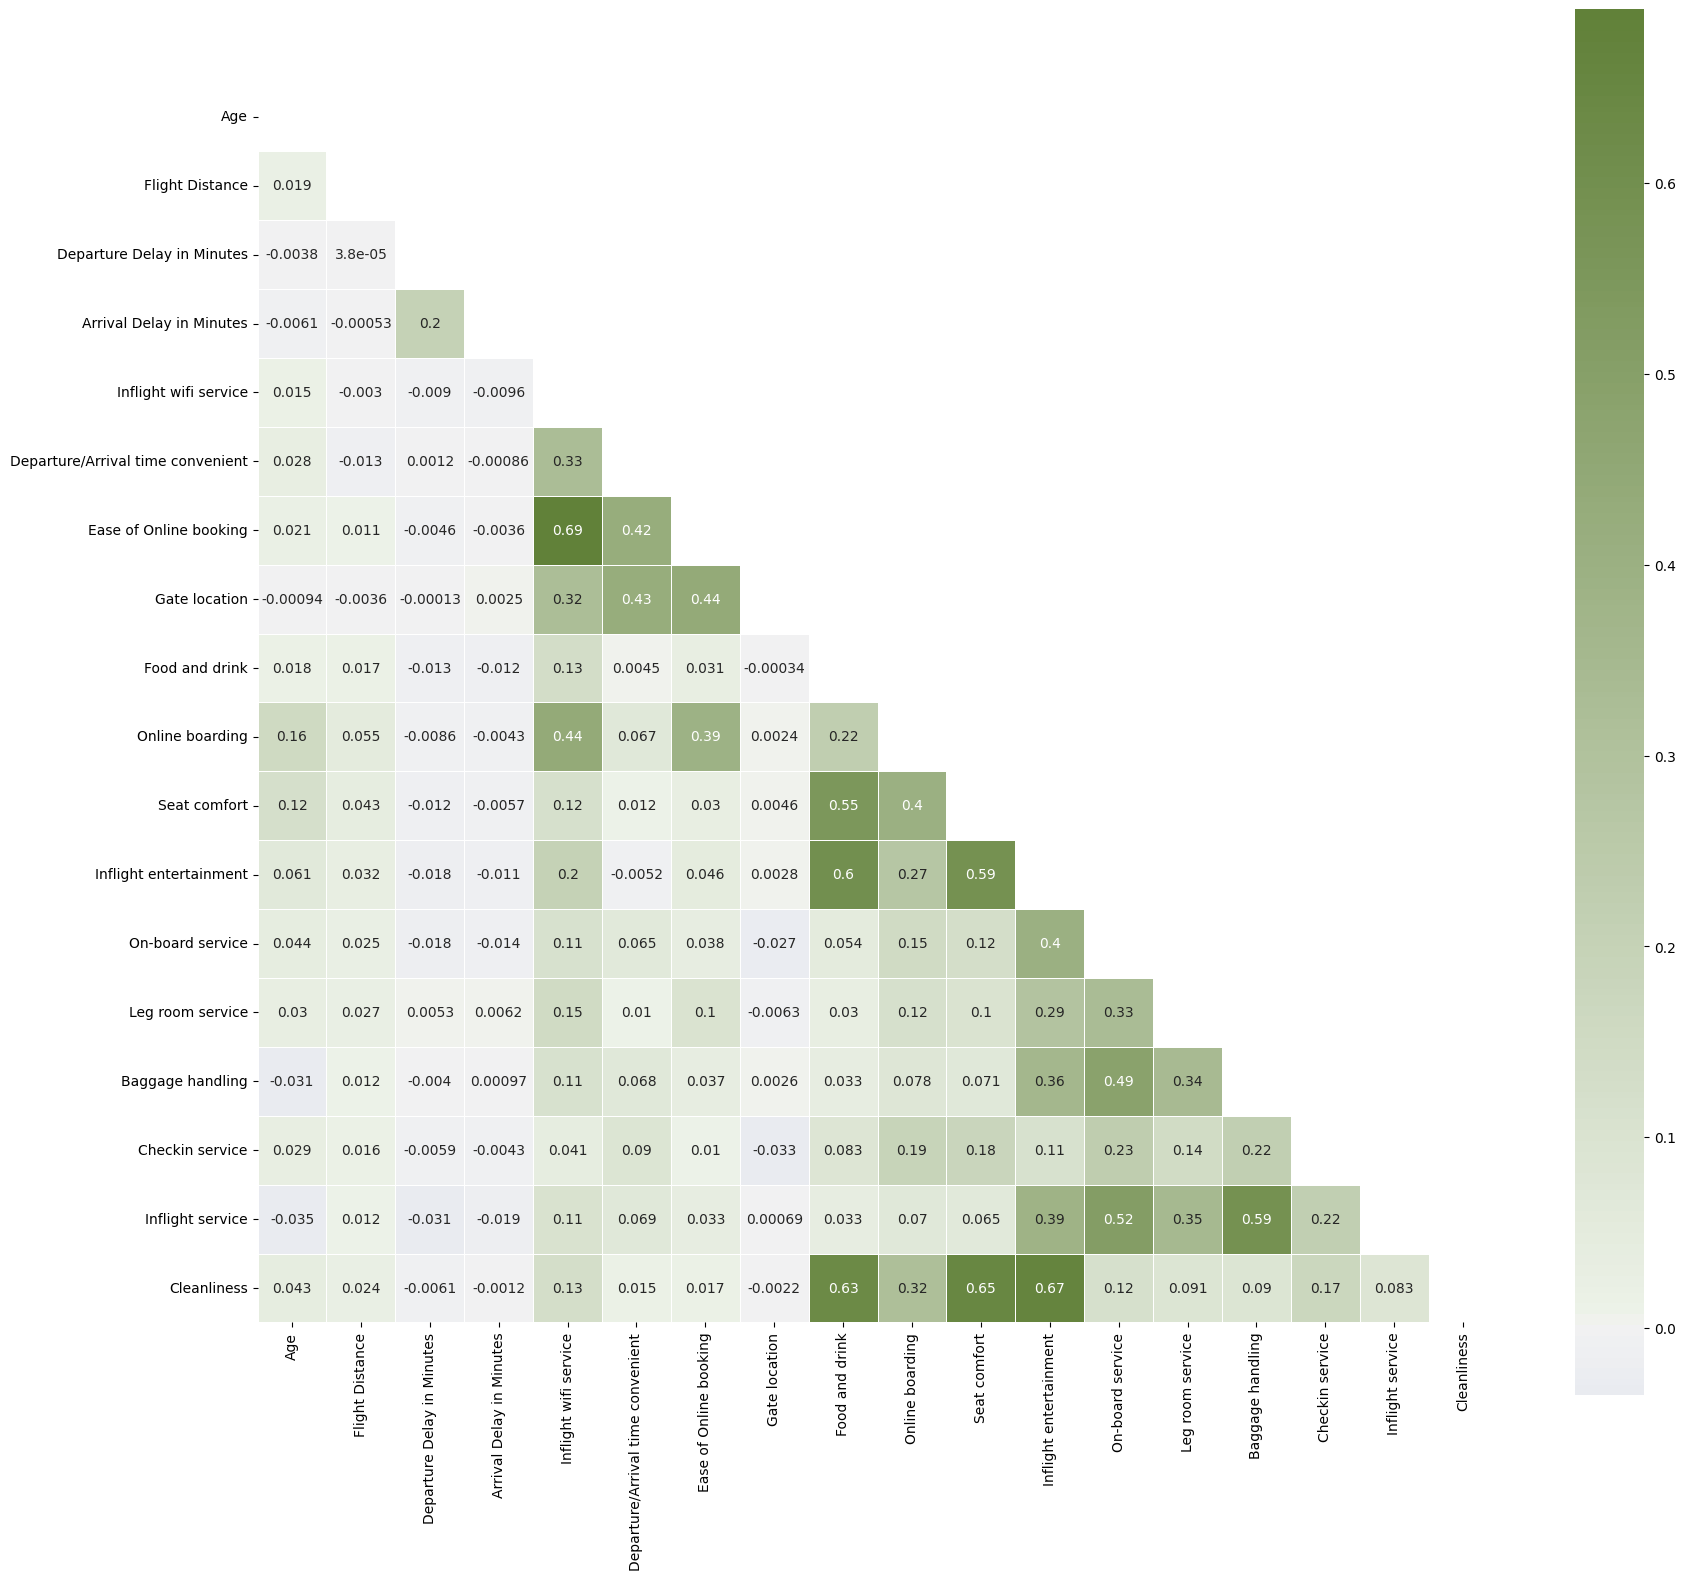

In [40]:
df_corr = df.drop(['id'], axis=1)
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(255, 110, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})


Некоторые параметры, характеризующие удобство полёта, заметно коррелируют, но исключать какой-то из них нет необходимости.

### Дискретные (категориальные и часть численных) признаки

In [41]:
def select_columns(df: pd.DataFrame, threshold: int = 100) -> list[str]:
    """
    Функция для выделения признаков с дискретными и непрерывными значениями.
    threshold определяет минимальное число уникальных значений, чтобы считать признак непрерывным.

    Источник: https://www.kaggle.com/code/ricktenbult/airline-satisfaction-prediction?scriptVersionId=134126604&cellId=11
    """
    
    #
    discrete_columns = []

    for column in df.columns:
        if df[column].nunique() <= threshold:
            discrete_columns.append(column)
    
    continuous_columns = [col for col in df.columns.tolist() if col not in discrete_columns]

    return discrete_columns, continuous_columns

In [42]:
def visualise_discrete(df: pd.DataFrame, discrete_columns: list[str]):
    """
    Функция для построения гистограммы по каждому признаку с дискретными значениями.

    Источник: https://www.kaggle.com/code/ricktenbult/airline-satisfaction-prediction?scriptVersionId=134126604&cellId=14
    """

    #categorical_columns = df.select_dtypes(include=['object'])
    #categorical_columns = ['Class', 'satisfaction']
    # Настройка размеров изображения
    fig, axes = plt.subplots(nrows=len(discrete_columns), ncols=2, figsize=(12, 6 * len(discrete_columns)))
    fig.subplots_adjust(hspace=0.25)
    sns.color_palette("Blues", as_cmap=True)
    
    for index, column in enumerate(discrete_columns):
        # Распределение по классам
        sns.countplot(data=df, x=column, ax=axes[index, 0], palette="blend:#7AB,#EDA")
        axes[index, 0].set_title(f"Countplot of {column}")
        axes[index, 0].set_xlabel("")

        # Распределение удовлетворённых внутри каждого класса
        sns.countplot(data=df, x=column, hue=TARGET, ax=axes[index, 1], palette="blend:#7AB,#EDA")
        axes[index, 1].set_title(f"Countplot of {column} specified by {TARGET}")
        axes[index, 1].set_xlabel("")  

    plt.show()

In [43]:
# Выделение признаков, которым должны соответствоватьчисла 0-5 и удаление выбросов
discrete_num_features = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location',
                 'Food and drink', 'Online boarding',
                 'Seat comfort',
                 'Inflight entertainment',
                 'On-board service',
                 'Leg room service',
                 'Baggage handling',
                 'Checkin service',
                 'Inflight service',
                 'Cleanliness']
for feature in discrete_num_features:
    df.drop(df[df[feature] > 5].index, inplace=True)


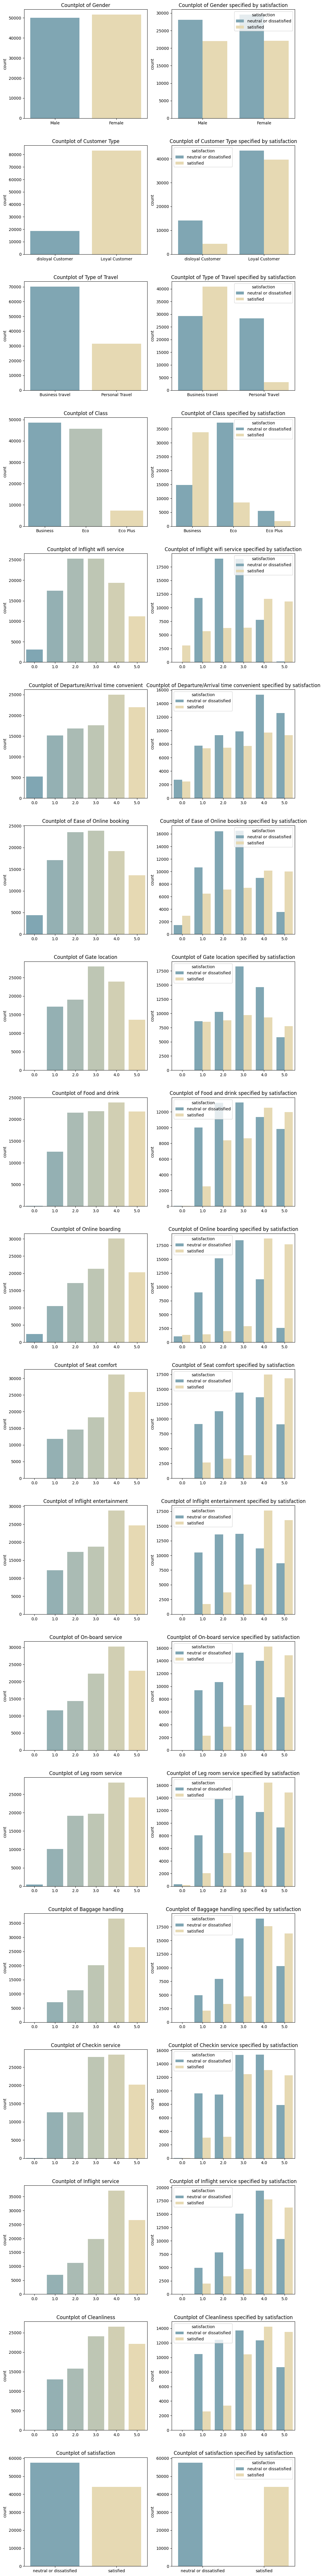

In [44]:
discrete_cols,_ = select_columns(df)
visualise_discrete(df, discrete_cols)

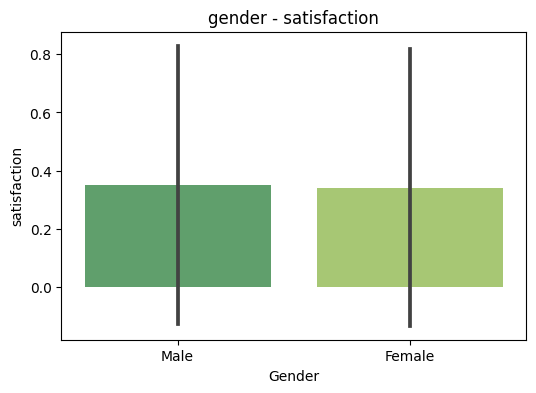

In [74]:
plt.figure(figsize=(6,4))

sns.barplot(x='Gender', y='satisfaction', data = df, palette='summer', errorbar='sd')
plt.title('gender - satisfaction')
plt.show()
# видимо, пол не влияет на удовлетворённость

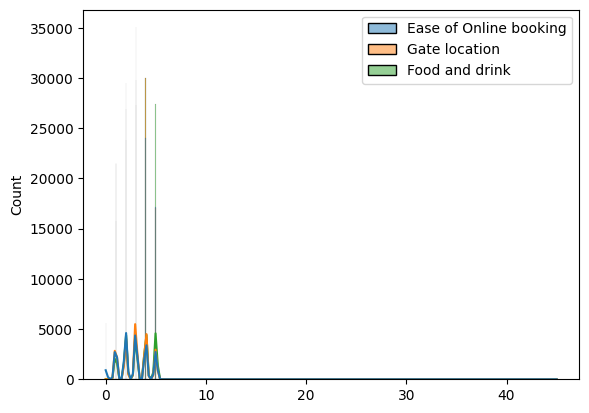

In [75]:
# Посмотрим на распределение оценок
sns.histplot(df[['Ease of Online booking', 'Gate location', 'Food and drink']], kde=True)
plt.show()

Видно, что в оценках есть выбросы

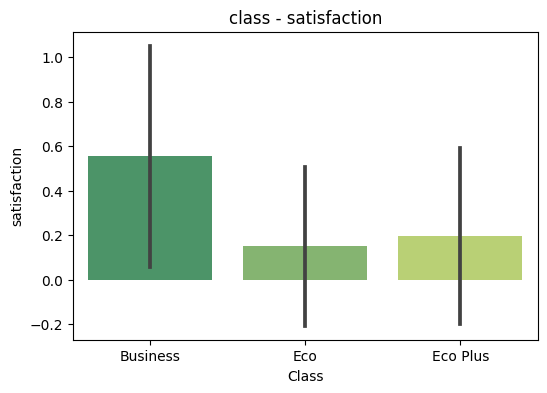

In [76]:
# Посмотрим на зависимость удовлетворённости от класса
plt.figure(figsize=(6,4))
sns.barplot(x='Class', y='satisfaction', data = df, palette='summer', errorbar='sd')
plt.title('class - satisfaction')
plt.show()

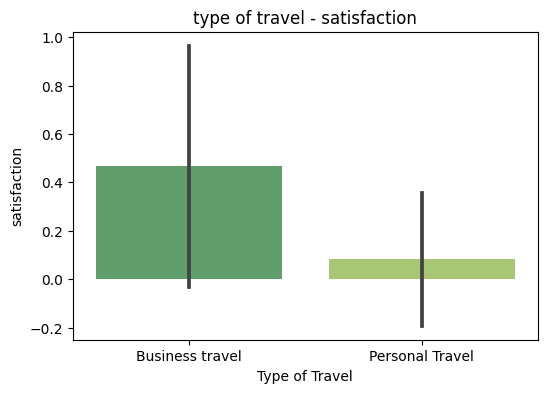

In [77]:
# Посмотрим на зависимость удовлетворённости от цели путешествия
plt.figure(figsize=(6,4))
sns.barplot(x='Type of Travel', y='satisfaction', data = df, palette='summer', errorbar='sd')
plt.title('type of travel - satisfaction')
plt.show()

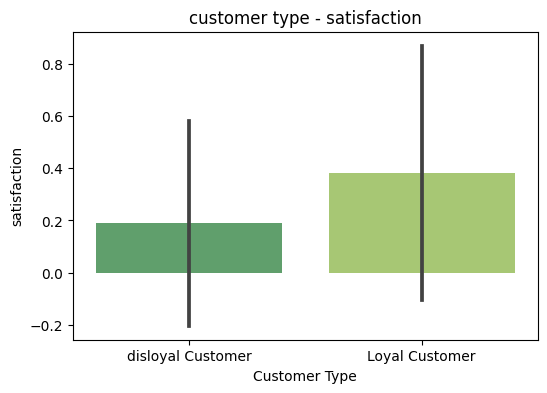

In [78]:
# Посмотрим на зависимость удовлетворённости от цели путешествия
plt.figure(figsize=(6,4))
sns.barplot(x='Customer Type', y='satisfaction', data = df, palette='summer', errorbar='sd')
plt.title('customer type - satisfaction')
plt.show()

На основании разведочного анализа можно сделать вывод о том,что на удовлетворённость, скорее всего, влияют:
* Customer Type
* Type of Travel
* Class
* Inflight wifi service
* Ease of Online booking
* Food and drink
* Online boarding
* Seat comfort
* Inflight entertainment
* On-board service
* Leg room service
* Baggage handling
* Checkin service
* Inflight service
* Cleanliness

In [79]:
# Список параметров с оценками от 1 до 5, которые, предположительно, влияют на удовлетворённость
important_marks = ['Inflight wifi service', 'Ease of Online booking', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 
                   'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness',
                   'Departure/Arrival time convenient', 'Gate location']
important_features = important_marks + ['Customer Type', 'Type of Travel', 'Class']

## Подготовка данных

In [80]:
df.describe()

,id,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
count,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000
mean,64955.143867,40.111799,1322.695057,15.736497,16.668122,2.732305,3.062506,2.760964,2.982046,3.208003,3.256646,3.445809,3.361517,3.387770,3.356407,3.636203,3.310366,3.647268,3.289419,0.346776
std,37485.969561,20.347785,4518.389937,93.597289,109.834910,1.360514,1.560027,1.431450,1.310838,1.357897,1.382403,1.346890,1.364325,1.336386,1.362215,1.218128,1.299473,1.214951,1.345837,0.475946
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32489.750000,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000
50%,64960.500000,40.000000,846.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000
75%,97404.250000,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1.000000
max,129880.000000,621.000000,379620.000000,22227.000000,14006.000000,45.000000,45.000000,45.000000,36.000000,45.000000,40.000000,45.000000,45.000000,45.000000,40.000000,40.000000,45.000000,36.000000,45.000000,1.000000


### Кодировка категориальных признаков

In [81]:
# Gender: female - 0, male - 1
df['Gender'] = df['Gender'].apply(lambda gender: 0 if gender == 'Female' else 1)

In [82]:
# Customer type: disloyal - 0, loyal - 1
df['Customer Type'] = df['Customer Type'].apply(lambda type: 1 if type == 'Loyal Customer' else 0)

In [83]:
# Превратим Type of Travel в численную характеристику. Непонятно, как определить отношение порядка на типах, поэтому добавим 2 новых признака:
pd.get_dummies(data=df, prefix=['Travel'],columns=['Type of Travel'])

,id,Gender,Age,Customer Type,Class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Travel_Business travel,Travel_Personal Travel
0,1,1,48.0,0,Business,821.0,2.0,5.0,3.0,3.0,...,5.0,3.0,2.0,5.0,4.0,5.0,5.0,0,1,0
1,2,0,35.0,1,Business,821.0,26.0,39.0,2.0,2.0,...,5.0,5.0,5.0,5.0,3.0,5.0,5.0,1,1,0
2,3,1,41.0,1,Business,853.0,0.0,0.0,4.0,4.0,...,3.0,3.0,3.0,3.0,4.0,3.0,5.0,1,1,0
3,4,1,50.0,1,Business,1905.0,0.0,0.0,2.0,2.0,...,5.0,5.0,5.0,5.0,3.0,5.0,4.0,1,1,0
4,5,0,49.0,1,Business,3470.0,0.0,1.0,3.0,3.0,...,3.0,3.0,4.0,3.0,3.0,3.0,5.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,129875,0,55.0,1,Eco Plus,308.0,0.0,0.0,3.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,0,0,1
129875,129876,1,28.0,1,Eco Plus,447.0,2.0,3.0,4.0,4.0,...,4.0,5.0,4.0,4.0,4.0,5.0,4.0,0,0,1
129877,129878,1,42.0,1,Eco Plus,337.0,6.0,14.0,2.0,5.0,...,3.0,3.0,4.0,5.0,4.0,4.0,3.0,0,0,1
129878,129879,1,50.0,1,Eco Plus,337.0,31.0,22.0,5.0,4.0,...,3.0,4.0,5.0,5.0,3.0,4.0,3.0,1,0,1


In [84]:
df = pd.get_dummies(data=df, prefix=['Travel'],columns=['Type of Travel'])

In [85]:
# Class закодировать проще: Eco - 0, Eco Plus - 1, Business - 2
df['Class'] = df['Class'].apply(lambda cl: 2 if cl == 'Business' else 1 if cl == 'Eco Plus' else 0)

In [86]:
for feature in important_marks:
    less = len(df[df[feature] < 1])
    greater = len(df[df[feature] > 5])
    print('{feature}: {less_count} < 1 and {greater_count} > 5'.format(feature = feature, less_count = less, greater_count = greater))

Inflight wifi service: 3868 < 1 and 34 > 5
Ease of Online booking: 5598 < 1 and 29 > 5
Food and drink: 134 < 1 and 32 > 5
Online boarding: 3034 < 1 and 34 > 5
Seat comfort: 6 < 1 and 42 > 5
Inflight entertainment: 23 < 1 and 25 > 5
On-board service: 9 < 1 and 28 > 5
Leg room service: 592 < 1 and 41 > 5
Baggage handling: 6 < 1 and 28 > 5
Checkin service: 6 < 1 and 38 > 5
Inflight service: 6 < 1 and 42 > 5
Cleanliness: 19 < 1 and 27 > 5
Departure/Arrival time convenient: 6575 < 1 and 39 > 5
Gate location: 1 < 1 and 41 > 5


Все оценки ниже одного можно приравнять к одному, так как это, скорее всего, и так должна была быть наименьшая оценка. Тех, кто поставил больше 5, значительно меньше и проще их исключить из выборки, так как непонятно, исходя из какого максимума они ставили оценку - 45 это 45 из 100 или 45 из 50, например.

In [87]:
for feature in important_marks:
    #df[feature] = df[feature].apply(lambda mark: min(max(int(mark), 1), 5))
    df[feature] = df[feature].apply(lambda mark: min(int(mark), 5))

Проверим, что теперь все признаки готовы для анализа

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127604 entries, 0 to 129879
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 127604 non-null  int64  
 1   Gender                             127604 non-null  int64  
 2   Age                                127604 non-null  float64
 3   Customer Type                      127604 non-null  int64  
 4   Class                              127604 non-null  int64  
 5   Flight Distance                    127604 non-null  float64
 6   Departure Delay in Minutes         127604 non-null  float64
 7   Arrival Delay in Minutes           127604 non-null  float64
 8   Inflight wifi service              127604 non-null  int64  
 9   Departure/Arrival time convenient  127604 non-null  int64  
 10  Ease of Online booking             127604 non-null  int64  
 11  Gate location                      1276

In [89]:
df.describe()

,id,Gender,Age,Customer Type,Class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Travel_Business travel,Travel_Personal Travel
count,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,...,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000,127604.000000
mean,64955.143867,0.492539,40.111799,0.816840,1.029623,1322.695057,15.736497,16.668122,2.729107,3.058580,...,3.358562,3.383562,3.351392,3.632543,3.306950,3.643005,3.286206,0.346776,0.690668,0.309332
std,37485.969561,0.499946,20.347785,0.386799,0.962638,4518.389937,93.597289,109.834910,1.329977,1.527168,...,1.334228,1.287394,1.316312,1.180149,1.266733,1.176918,1.313617,0.475946,0.462220,0.462220
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32489.750000,0.000000,27.000000,1.000000,0.000000,414.000000,0.000000,0.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,64960.500000,0.000000,40.000000,1.000000,1.000000,846.000000,0.000000,0.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,1.000000,0.000000
75%,97404.250000,1.000000,51.000000,1.000000,2.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1.000000,1.000000,1.000000
max,129880.000000,1.000000,621.000000,1.000000,2.000000,379620.000000,22227.000000,14006.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000


## Машинное обучение

In [90]:
# Оставим в таблице только нужные признаки
important_features.remove('Type of Travel')
important_features.append('Travel_Business travel')
important_features.append('Travel_Personal Travel')

X = df[important_features]
y = df['satisfaction']

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape

((95703, 18), (31901, 18))

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = LogisticRegression()

model.fit(X_train, y_train)

pred = model.predict(X_test)

/home/dmitry/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.8199429484969123

In [94]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred)

array([[18036,  2780],
       [ 2962,  8123]])

In [95]:
pred1 = pipe.predict(X_test)
confusion_matrix(y_test, pred1)

array([[18042,  2774],
       [ 2970,  8115]])

In [96]:
# You can optimize the iterations, learning rate and also evaluation metrics 
### classifier 
from catboost import CatBoostClassifier 

cat_features = ['Gender', 'Customer Type', 'Travel_Business travel', 'Travel_Personal Travel', 'Class', 'Seat comfort',
               'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
               'Inflight wifi service', 'Inflight entertainment',
               'Ease of Online booking', 'On-board service', 'Leg room service',
               'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

target = 'satisfaction'
"""
cat_features = important_features

"""
X = df.drop([target], axis = 1)
X['Age'] = X['Age'].apply(lambda x: int(x))
X['Flight Distance'] = X['Flight Distance'].apply(lambda x: int(x))
X['Arrival Delay in Minutes'] = X['Arrival Delay in Minutes'].apply(lambda x : int(x))
X['Departure Delay in Minutes'] = X['Departure Delay in Minutes'].apply(lambda x : int(x))


y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['Accuracy'],
    eval_metric='Accuracy' 
)

## when you fit the model with parameter plot=True, you can see how your model is training (it is fun!)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    logging_level='Silent',
    plot=True
) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))